In [13]:
import os
import json
import string

import umap
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import CountVectorizer

from ctfidf import CTFIDFVectorizer
from wordcloud import WordCloud

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
stopwords_de = stopwords.words('german')
stopwords_en = stopwords.words('english')

with open(os.getcwd()+'/../../conf/stopwords_de.txt', 'r') as f:
    stopwords_de_extra = f.read().splitlines()

stopwords_full = []
stopwords_full.extend(stopwords_de)
stopwords_full.extend(stopwords_en)
stopwords_full.extend(stopwords_de_extra)

stopwords_full = [word.lower() for word in stopwords_full]

stop_all = set(stopwords_full + list(string.punctuation))

In [3]:
train_df = pd.read_pickle(os.getcwd() + '/../dataframes/train_df.pkl')
train_df['dummy'] = 1
train_df.sample(2)

,id,text,label,lang,label_name,doc_vec,dummy
350,210705_news_575,In Brandenburg und in Sachsen wird in weni...,0,de,negative,"[[-0.07425029, 0.019686725, 0.050809357, 0.027...",1
36,210705_news_792,"Le Bourget (ww) Zu Lande, zu Wasser, in der Lu...",1,de,technology,"[[-0.037918102, -0.008029297, 0.07452733, 0.00...",1


In [16]:
def remove_stop_words(text):
    
    word_list = []
    for word_token in word_tokenize(text.lower()):
        if word_token not in stop_all:
            word_list.append(word_token)
            
    return ' '.join(word_list)

def show_wordcloud(cluster_id):
    
    cluster_docs = list(train_df[train_df['label'] == cluster_id]['text_clean'].values)
    combined_txt = ' '.join(cluster_docs)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(combined_txt)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [5]:
train_df['text_clean'] = train_df.apply(lambda x:remove_stop_words(x['text']), axis=1)

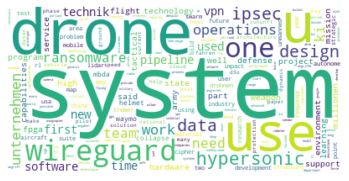

In [17]:
show_wordcloud(1)

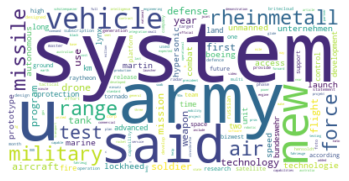

In [18]:
show_wordcloud(2)

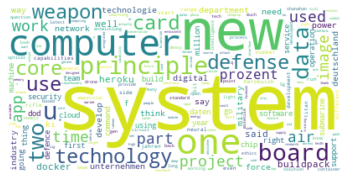

In [19]:
show_wordcloud(3)

In [23]:
train_df.label.value_counts()

0    264
3     75
2     55
1     37
Name: label, dtype: int64

In [22]:
positive_df = train_df[train_df['label'] == 1]
negative_df = train_df[train_df['label'] == 2 or train_df['label'] == 3]

i = 0
for idx, row in positive_df.iterrows():
    if '5G' in row['text']:
        i += 1
#         print(row['text'])
#         print('\n\n')

print(i)

13


In [7]:
def get_umap_output(vec_array, dim_size=5):
    
    umap_obj = umap.UMAP(n_neighbors=40, 
                        n_components=dim_size, 
                        min_dist=0.01,
                        metric='cosine',
                        random_state=123).fit(vec_array) 
    
    umap_output = umap_obj.transform(vec_array) 
    return umap_output, umap_obj

def get_gmm_output(data_points, cluster_size=7):
    
    gmm_output = GaussianMixture(n_components=cluster_size, covariance_type='full', random_state=12).fit(data_points)
    
    return gmm_output

def get_topwords_per_class(df, topn=10):
    
    docs = pd.DataFrame({'Document': df.text_clean, 'Class': df.cluster_id})
    docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

    # Create bag of words
    count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
    count = count_vectorizer.transform(docs_per_class.Document)
    words = count_vectorizer.get_feature_names()

    # Extract top 10 words
    ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()
    words_per_class = {label: [words[index] for index in ctfidf[label].argsort()[-topn:]] for label in docs_per_class.Class}
    
    return words_per_class

def get_analysis_df(words_per_class, df, label_class):
    
    df_top10 = pd.DataFrame(words_per_class).T
    df_top10['cluster_id'] = df_top10.index

    df_map = pd.pivot_table(df, columns=label_class, index=['cluster_id'], aggfunc='count', values='dummy').reset_index()
    # df_map.drop('doc_label', axis=1, inplace=True)
    df_map.rename(columns={0: 'neg', 1: 'tech', 2:'milt'}, inplace=True)

    final_df = df_map.merge(df_top10, on='cluster_id', how='inner')
    final_df.fillna(0, inplace=True)
#     final_df['total'] = final_df.apply(lambda x:x['neg']+x['pos'],axis=1)
#     final_df['pos_ratio'] = final_df.apply(lambda x:x['pos']/x['total'],axis=1)
#     final_df.sort_values('pos', ascending=False, inplace=True)
    
#     clustering_score = 0
#     pos_ratio_limit = 0.3
    
#     for pos, pos_ratio in zip(final_df.pos.values, final_df.pos_ratio.values):
#         if pos > 1 and pos_ratio >= pos_ratio_limit:
#             clustering_score += 1
            
#     final_df = final_df[((final_df['pos'] > 1) & (final_df['pos_ratio'] >= pos_ratio_limit)) | (final_df['cluster_id'] == -1)]
            
    return final_df

def get_clustering_analysis(df, label_class, col='doc_vec', dimen_size=5, cluster_size=7, topn=10):
    
    vecs = []
    for vec in df[col].values:
        vecs.append(vec.tolist())
    vec_array = np.array(vecs)
    
    vec_array = vec_array.reshape(vec_array.shape[0], vec_array.shape[-1])
    print(vec_array.shape)
    
    umap_output_5, umap_5 = get_umap_output(vec_array, dim_size=dimen_size)
    gmm = get_gmm_output(umap_output_5, cluster_size=cluster_size)

    df['cluster_id'] = gmm.predict(umap_output_5)
    words_per_class = get_topwords_per_class(df, topn)
    
    analysis_df = get_analysis_df(words_per_class, df, label_class)
    
    return analysis_df

def get_clustering_result(label, cluster_cnt):
    
    train_df_sample = train_df[train_df['label'] == label]
    analysis_df = get_clustering_analysis(train_df_sample, 'label', col='doc_vec', dimen_size=5, cluster_size=cluster_cnt, topn=15)
    
    return analysis_df

In [ ]:
get_clustering_result(1, cluster_cnt=20)

In [68]:
get_clustering_result(1, cluster_cnt=20)

(37, 512)


,cluster_id,tech,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,2,code,fehlerquote,post,imagenet,übersetzen,kryptografie,handlungsempfehlungen,programmiersprachen,algorithmus,verfahren,quanten,ibm,bsi,quantencomputer,codenet
1,1,2,infrared,urban,integrated,contractors,new,four,high,hypersonic,darpa,rf,tactics,aperture,materials,heat,swarm
2,2,2,enforcement,materialien,defense,shell,comfort,weight,pad,confidence,impact,head,pads,trust,protection,d3o,helmet
3,3,2,entwicklung,000,fahrzeug,mai,unfälle,autos,september,autonome,2020,meilen,chinesische,fahrzeuge,fahren,china,waymo
4,4,2,ferrin,tiefenkarte,iphone,ii,grant,sensor,vi,environments,cameras,asi,radar,apple,deep,learning,lidar
5,5,3,2019,anschlüsse,twh,reactor,department,project,gigabyte,millionen,2020,energy,jahr,nuclear,milliarden,bundesnetzagentur,pele
6,6,2,regierung,lösegeld,infrastruktur,technik,hacker,ansatz,fälle,pipelines,behörden,it,usa,us,kratsios,ki,pipeline
7,7,1,lieferdrohne,lift,kilometer,starrflügler,drohnenhersteller,cm,zuladung,km,drohne,kilogramm,upsff,multicopter,drohnen,ups,wingcopter
8,8,2,point,use,work,ip,paper,suite,like,tremer,cipher,hardware,fpga,vpn,one,ipsec,wireguard
9,9,1,lösen,football,forscherteam,forschern,tpus,trace,gpus,framework,cloud,impala,tausende,inferenz,google,seed,rl


In [66]:
get_clustering_result(2, cluster_cnt=30)

(55, 512)


,cluster_id,milt,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,3,fahrzeug,development,system,modernisierung,mobility,ads,integriert,rheinmetall,aps,strikeshield,panzer,vehicle,programme,countries,patria
1,1,1,millionen,bieten,auftrag,angesichts,debatte,400,2030,februar,luftwaffe,2025,2021,radarwarngeräte,tornado,saab,tornados
2,2,1,smart,safety,prototypes,efficiency,members,project,solicitations,technologies,enabled,spectrum,cases,base,warehouse,consortium,5g
3,3,6,variante,russischen,truppen,400,software,phase,wellenformen,sdr,2019,mission,übung,svfua,master,soveron,rheinmetall
4,4,2,said,interceptor,patriot,second,satellite,smc,interceptors,gps,martin,lockheed,mse,iii,launch,space,pac
5,5,2,reney,gluas,device,said,atomics,aircraft,mq,service,gerdes,unmanned,drone,grenade,reaper,corps,marine
6,6,2,traffic,durchschauen,integrierten,flughafen,mitteilung,management,mr,lösungen,flir,falke,hamburg,ranger,hdc,frequentis,hensoldt
7,7,2,future,textron,flight,demo,officials,aircraft,rotor,knots,helicopter,aviation,effort,flraa,bell,black,sikorsky
8,8,2,vehicle,made,machine,fire,even,gun,armour,compartment,platform,export,russian,combat,tank,russia,boomerang
9,9,1,lynx,commonwealth,ausgewählt,erprobungsphase,regierung,liefern,rheinmetalls,mitigation,ort,schützenpanzer,rheinmetall,mrd,arbeitsplätzen,anbieter,konzern


In [67]:
get_clustering_result(0, cluster_cnt=50)

(264, 512)


,cluster_id,neg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,11,mittelstand,wirtschaft,focus,idee,altmaier,fernspäher,luftwaffe,kettner,höhle,ideen,eltern,löwen,kinder,unternehmen,digitalisierung
1,1,4,fachartikel,informationstechnik,00,rüstung,koblenz,monate,news,baainbw,bundeswehr,bwfuhrparkservice,esut,sicherheit,bestellen,tageszugang,digital
2,2,5,soldaten,zahl,august,zeitsoldaten,kondratyuk,dienst,juli,mai,frauen,soldatinnen,2018,2017,2019,2016,bundeswehr
3,3,1,takt,vega6,ces,nanometer,45,prozessor,prozessoren,15,4800h,notebooks,watt,kerne,ghz,amd,ryzen
4,4,12,systems,bae,new,aircraft,contract,vehicle,test,amphibious,navy,said,vehicles,iii,marine,marines,corps
5,5,2,größere,aufnahme,atmosphäre,mischung,wasser,fischen,reusch,mengen,gasparella,kohlenstoff,kohlendioxid,co,meer,ozean,mikroplastik
6,6,2,manifestdatei,verbinden,profils,paketverwaltungs,weise,lässt,package,schema,pakete,querys,software,api,gnu,graphql,guix
7,7,8,jahren,berlin,rechtsextremisten,datenbank,rörig,anschläge,polizei,prozess,eurojust,franco,bank,ex,cum,angeklagten,bka
8,8,4,queen,populism,local,migrantenorganisationen,organisationen,kompetent,spending,kandidaten,politics,prozent,new,speech,giffey,cummings,johnson
9,9,9,attacke,angriffe,imsi,kaseya,files,numbers,okta,kunden,messages,phone,messagetap,researchers,angreifer,schwachstellen,malware
